In [1]:
%pylab inline
from sys import platform
from tqdm import trange
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

if platform == "win32":
    path = 'C:User/olive/'
elif platform == "darwin":
    path = '~/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
### LOADS PROCESSED DATA

c_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

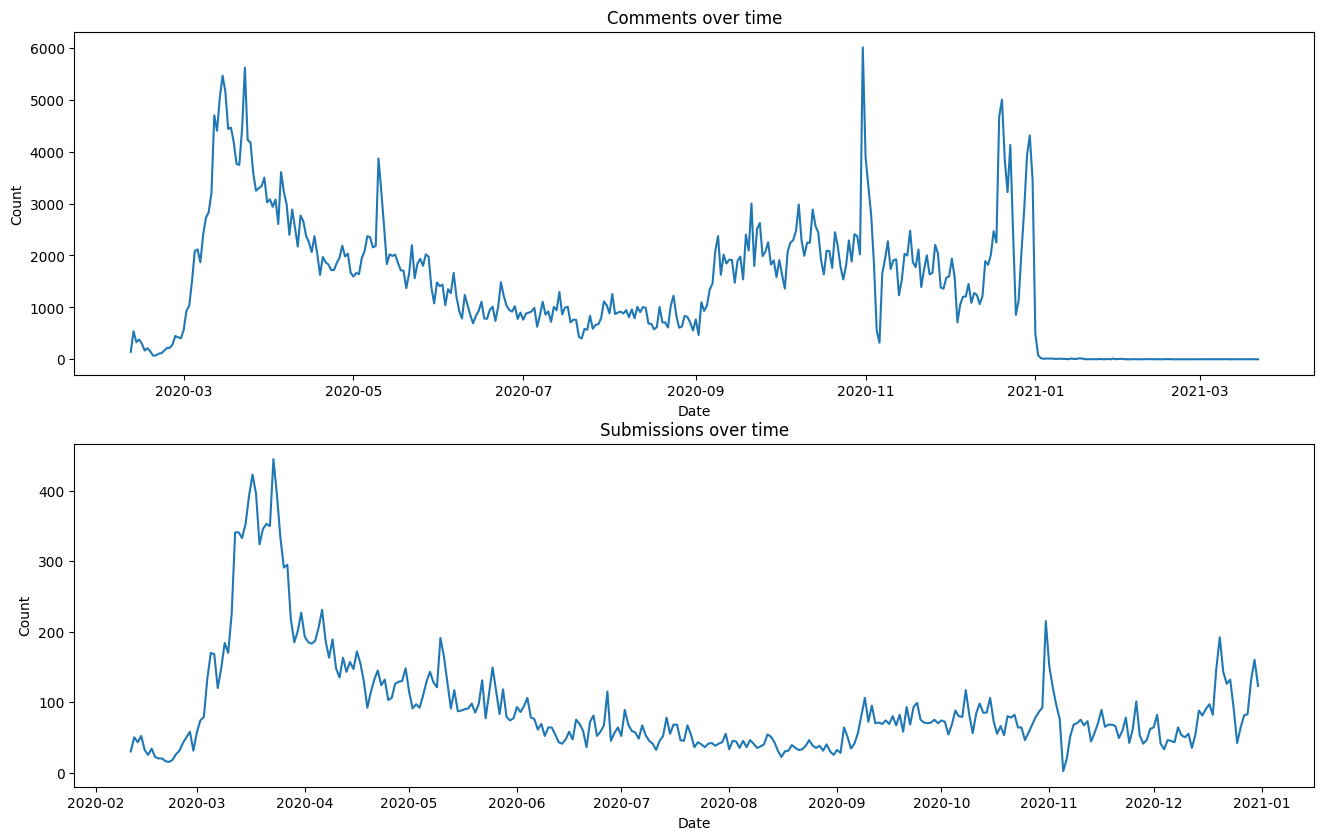

In [3]:
s_df = s_df.sort_values(by='datetime')
c_df = c_df.sort_values(by='datetime')

comments = c_df['datetime'].dt.date.value_counts()
submissions = s_df['datetime'].dt.date.value_counts()

submissions = submissions.sort_index(ascending=True)
comments = comments.sort_index(ascending=True)

fig, (ax1, ax2) = plt.subplots(2, dpi=100)
fig.set_size_inches(16, 10)

ax1.set_title('Comments over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax1.plot(comments.index, comments.values)

ax2.set_title('Submissions over time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Count')
ax2.plot(submissions.index, submissions.values)

In [7]:
c_df = c_df.sort_values(by='datetime')

positive_data = c_df.groupby(
    c_df['submission_id'],
    as_index = False
).agg(
    {
        'compound_score': mean
    }
)
positive_data
# negative_data = c_df.query('sentiment == "negative"')

# plt.plot(positive_data, 'g')

# fig, (ax1, ax2, ax3) = plt.subplots(3, dpi=100)
# fig.set_size_inches(16, 10)

# ax1.set_title('Positive sentimnet over time')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Sentiment')
# ax1.plot(positive_data['datetime'].dt.date, positive_data['compound_score'])

# ax2.set_title('Neutral sentiment over time')
# ax2.set_xlabel('Date')
# ax2.set_ylabel('Sentiment')
# ax2.plot(submissions.index, submissions.values)

# ax3.set_title('Negative sentiment over time')
# ax3.set_xlabel('Date')
# ax3.set_ylabel('Sentiment')
# ax3.plot(submissions.index, submissions.values)

,submission_id,compound_score
0,f24dhg,0.000000
1,f258wn,0.079067
2,f28jys,0.082594
3,f28qo8,0.056383
4,f29uk8,-0.334567
...,...,...
24633,knz7td,0.067178
24634,knz9lb,0.248309
24635,knzrld,0.146821
24636,knzv9k,-0.434000


In [ ]:
# Mean entiment analysis compound score for every comment over time

positive_data = c_df.query(
    'sentiment == "positive"'
).groupby(
    c_df['datetime'].dt.date
).agg(
    {
        'compound_score': mean
    }
)

neutral_data = c_df.query(
    'sentiment == "neutral"'
).groupby(
    c_df['datetime'].dt.date
).agg(
    {
        'compound_score': mean
    }
)


negative_data = c_df.query(
    'sentiment == "negative"'
).groupby(
    c_df['datetime'].dt.date
).agg(
    {
        'compound_score': mean
    }
)

plt.plot(positive_data, 'g-')
plt.plot(neutral_data, '#808080')
plt.plot(negative_data, 'r-')

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(comments)

In [4]:
c_df.sample(10)

,datetime,body,sentiment,compound_score,submission_id,parent_id
id,,,,,,
fl6rnzj,2020-03-22 12:46:19,Call him “Corona Colin” until he gets the idea.,neutral,0.0000,fmyezr,t1_fl6paw2
gal6u9x,2020-10-30 10:53:45,I chat over Skype with my parents in their own...,negative,-0.6867,jku2dj,t3_jku2dj
fpl0yli,2020-05-05 19:47:31,"Omg, congratulations!!!! I absolutely love kid...",positive,0.9715,gdwfmv,t1_fpkfm5w
fq0jumt,2020-05-09 15:03:53,"You mention you both have had ""very little int...",positive,0.7003,gg6oac,t1_fq0hsul
fqaizh0,2020-05-11 18:57:54,My 86 year old nan was in hospital for a hip r...,positive,0.7779,ghkupt,t3_ghkupt
fruwxtk,2020-05-26 11:38:35,Primark was trending on twitter yesterday afte...,positive,0.4588,gqqbns,t1_frufn1b
g7wjie2,2020-10-06 16:38:18,Just echoing what others have said. You have a...,positive,0.8271,j63apl,t3_j63apl
ggu010e,2020-12-23 21:02:46,Not long. There will probably be a Tier 5 to r...,neutral,0.0000,kj0sh9,t3_kj0sh9
g8aw7sw,2020-10-10 10:51:32,Could easily be a spam.After all the spammers ...,negative,-0.5106,j8fyel,t3_j8fyel
